In [1]:
import numpy as np
import sobol_seq
import matplotlib.pyplot as plt
from functools import partial
from typing import List, Optional, Callable, Tuple


Problem 1 Paper Pak Kun

In [2]:
# NP = 100 # number of population
# gen_max = 100 # maximum number of fitness evaluation
# F_init = 0.3 # mutation factor
# CR_init = 0.7 # crossover rate
# delta = 0.1

# seed = 121

# epsilon = 1e-3
# gamma = -0.2
# m_cluster = 250

# dim = 2
# boundaries = np.array([(-10,10) for _ in range (dim)])

# def objective_function(x):
#     f1 = np.exp(x[0]-x[1])-np.sin(x[0]+x[1])
#     f2 = (x[0]*x[1])**2-np.cos(x[0]+x[1])
#     return np.array([f1,f2])


Problem 2 Paper Pak Kun

In [3]:
NP = 100 # number of population
gen_max = 100 # maximum number of fitness evaluation
F_init = 0.3 # mutation factor
CR_init = 0.7 # crossover rate
delta = 0.1

seed = 121

epsilon = 1e-3
gamma = -0.3
m_cluster = 2000

dim = 2

def objective_function(x):
    f1 = 0.5*np.sin(x[0]*x[1])-0.25*x[1]/np.pi - 0.5*x[0]
    f2 = (1-0.25/np.pi)*(np.exp(2*x[0])-np.exp(1))+np.exp(1)*x[1]/np.pi - 2*np.exp(1)*x[0]
    return np.array([f1,f2])

boundaries = np.array([(-1,3),(-17,4)])

Problem 4 Paper Pak Kun

In [4]:
# NP = 100 # number of population
# gen_max = 100 # maximum number of fitness evaluation
# F_init = 0.3 # mutation factor
# CR_init = 0.7 # crossover rate
# delta = 0.5

# seed = 121

# epsilon = 1e-3
# gamma = -0.001
# m_cluster = 2000

# dim = 3

# def objective_function(x):
#     f1 = x[0]*x[1]-(x[0]-2*x[2])*(x[1]-2*x[2])-165
#     f2 = (x[0]*x[1]**3)/12-((x[0]-2*x[2])*(x[1]-2*x[2])**3)/12-9369
#     f3 = (2*(x[1]-x[2])**2*(x[0]-x[2])**2*x[2])/(x[1]+x[0]-2*x[2])-6835
#     return np.array([f1,f2,f3])

# boundaries = np.array([(-40,40) for _ in range (dim)])

In [5]:
def root_objective_function(x:np.ndarray):
    F_array = objective_function(x)
    denom = 0
    for f in F_array:
        denom += np.abs(f)
    res = 1/(1+denom)
    return -res

In [6]:
"""GENERATE POINTS USING SOBOL SEQUENCE"""
def generate_points(dim: int,
                    npoint:int,
                    low=-10,
                    high=10):
    if type(low) != type(high):
        raise TypeError('The type of "low" and "high" should be the same.')
    if type(low) == int:
        boundaries = [(low,high) for _ in range (dim)]
    elif type(low) == list or type(low) == np.ndarray:
        if len(low) != len(high):
            raise TypeError('The length of "low" and "high" should be the same.')
        else:
            boundaries = [(low[i],high[i]) for i in range (len(low))]

    # Generate Sobol sequence points
    sobol_points = sobol_seq.i4_sobol_generate(dim, npoint)

    # Scale the Sobol points to fit within the specified boundaries
    scaled_points = []
    for i in range(dim):
        a, b = boundaries[i]
        scaled_dim = a + sobol_points[:, i] * (b - a)
        scaled_points.append(scaled_dim)

    # Transpose the scaled points to get points per dimension
    scaled_points = np.array(list(map(list, zip(*scaled_points))))
    return scaled_points

"""MAXIMIZE FUNCTION"""
def minimize(set_of_points):
    z = []
    z_min = 0
    F = root_objective_function(set_of_points.T)
    for i in range (len(set_of_points)):
        if len(set_of_points.T) == 1: # ini sifat dari numpy python dimana arraynya malah dobel klo ga diginiin
            z.append(root_objective_function(set_of_points.T)[0,i])
            if z[i]<z_min:
                z_min = z[i]
                idx_min = i
        else:
            z.append(root_objective_function(set_of_points.T)[i])
            if z[i]<z_min:
                z_min = z[i]
                idx_min = i
    x_min = set_of_points[idx_min]
    return z_min,idx_min,x_min

In [7]:
def mutation(xr1,xr2,xr3,scaling_factor):
    donor_vector = xr1 + scaling_factor*(xr2-xr3)
    return donor_vector

def crossover(individual:np.ndarray, honor_vector:np.ndarray, crossover_rate):
    trial_vector = np.zeros(shape=individual.shape)
    for j in range (individual.shape[0]):
        rand_j = np.random.random() # a uniformly distributed random number from [0, 1]
        j_rand = np.random.randint(dim+1) #a random integer uniformly generated from {1, . . . , n}
        if (rand_j<crossover_rate) | (j == j_rand):
            trial_vector[j] = honor_vector[j]
        else: #(rand_j>=CR) and (j != j_rand)
            trial_vector[j] = individual[j]
    return trial_vector


In [8]:
k = 0
k_cluster = 10
iter_points = {}
iter_points[0] = generate_points(dim=dim,
                        npoint=m_cluster,
                        low=boundaries[:,0],
                        high=boundaries[:,1])
x_prime = minimize(iter_points[0])[-1]
x_prime

array([0.55078125, 3.15917969])

In [9]:
min_boundaries = 10**100
for i in range (len(boundaries)):
    abs_disc = np.abs(boundaries[i,1]-boundaries[i,0])
    if abs_disc<=min_boundaries:
        min_boundaries = abs_disc
radius = min_boundaries/2
cluster_center,cluster_radius = {},{}
cluster_center[0],cluster_radius[0] = x_prime,radius
print(cluster_center,cluster_radius)

{0: array([0.55078125, 3.15917969])} {0: 2.0}


In [10]:
"""FUNCTION CLUSTER"""
def function_cluster(y,lendict):
    min_dist_cluster = 10**100
    for ci,cc in cluster_center.items():
        dist = np.linalg.norm(cc-y)
        if dist<=min_dist_cluster:
            xc = cc
            cluster_id = ci
            min_dist_cluster = dist
    xt = (xc + y)/2
    # print(f'xt={xt}, xc={xc}, y={y}')
    Fxt = -root_objective_function(xt)
    Fxc = -root_objective_function(xc)
    Fy = -root_objective_function(y)
    # print(f'Fxt={Fxt}, Fxc={Fxc}, Fy={Fy}')
    if (Fxt < Fy) & (Fxt < Fxc):
        cluster_center[lendict] = y
        cluster_radius[lendict] = np.linalg.norm(y-xt)
    elif (Fxt > Fy) & (Fxt > Fxc):
        cluster_center[lendict] = y
        cluster_radius[lendict] = np.linalg.norm(y-xt)
        function_cluster(xt,lendict+1)
    elif Fy > Fxc:
        cluster_center[cluster_id] = y

    cluster_radius[cluster_id] =  np.linalg.norm(y-xt)
    # return cluster_center,cluster_radius


In [11]:
import deal
while k<k_cluster:
    potential_cluster_center = []
    RoF = root_objective_function(iter_points[k].T)
    # print(RoF)
    for i in range (m_cluster):
        if len(iter_points[k].T) == 1:
            fungam = RoF[0][i]
        else:
            fungam = RoF[i]
        # print(f'fungan={fungam}')
        # print(f"iter_points[k][i]={iter_points[k][i]}")
        exist_in_cluster_center = any(np.linalg.norm(iter_points[k][i] - ctr) < epsilon for ctr in cluster_center[k])
        # print(exist_in_cluster_center)
        if (fungam < gamma) & (exist_in_cluster_center==False):
            potential_cluster_center.append(iter_points[k][i])
            # print(potential_cluster_center)
    # len(potential_cluster_center)
    # print('')
    for i in range (len(potential_cluster_center)):
        # print(f'Titik ke-{i}')
        lendict = len(list(cluster_center.keys()))
        function_cluster(potential_cluster_center[i],lendict)
        # print(f'cluster_center={cluster_center}\ncluster_radius={cluster_radius}\n')
        # print('')
    iter_points[k+1] = deal.reproduction(population=iter_points[k],
                                        objective_function=root_objective_function,
                                        dimension=dim,
                                        mutation_factor=F_init,
                                        crossover_rate=CR_init,
                                        seed=seed)
    k+=1
    # print(f'cluster_center={cluster_center}\ncluster_radius={cluster_radius}')
cluster_center,cluster_radius

({0: array([0.55078125, 3.15917969]),
  1: array([-0.24791831,  0.66255011]),
  2: array([ 1.17289258, -0.85184082]),
  3: array([-0.22996462,  0.76852054]),
  4: array([1.08398438, 0.33935547]),
  5: array([-0.51625897, -0.73862852]),
  6: array([  1.53515625, -10.86816406]),
  7: array([-0.15884766,  1.11762695]),
  8: array([  1.68164062, -17.18457031]),
  9: array([  1.640625  , -15.44140625]),
  10: array([0.51099198, 3.17844957]),
  11: array([-0.94646873, -3.11683684]),
  12: array([  1.5390625 , -10.15039062]),
  13: array([-0.5390625 , -0.88085938]),
  14: array([-0.03189548,  1.72214913]),
  15: array([0.87113574, 2.29138647]),
  16: array([ 1.3984375 , -5.88476562]),
  17: array([ 1.3046875 , -3.42382812]),
  18: array([-0.47265625, -0.53222656]),
  19: array([  1.59885293, -11.94757739]),
  20: array([0.47867396, 3.12076179]),
  21: array([-0.31795977,  0.31201855]),
  22: array([ 1.42899541, -6.70278279]),
  23: array([0.12773431, 2.27183637]),
  24: array([-0.86914062, -2

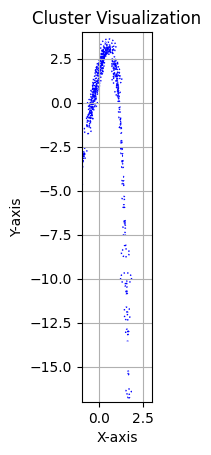

In [12]:
if dim != 2:
    print(f"Dimension {dim} cant be visualized using cluster_visualization2D.")
"""Visualization"""
fig, ax = plt.subplots()
for center,radius in zip(cluster_center.values(),cluster_radius.values()):
    circle = plt.Circle(center, radius, fill=False, linestyle='dotted', edgecolor='b')
    ax.add_artist(circle)

# Set axis limits
ax.set_xlim(boundaries[0])
ax.set_ylim(boundaries[1])
# ax.autoscale_view()

# # Add labels (optional)
# for i, center in cluster_center.items():
#     ax.text(center[0], center[1], f'Cluster {i+1}', ha='center', va='bottom')

# Add a title and labels (optional)
ax.set_title('Cluster Visualization')
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')

# Show the plot
plt.gca().set_aspect('equal', adjustable='box')  # Make the aspect ratio equal
plt.grid(True)
plt.show()

In [13]:
def cluster_boundaries(center_point,radius):
    return np.array([[center_point[i]-radius,center_point[i]+radius]for i in range (len(center_point))])

In [14]:
roots = []
roots_values = []
for i in range (len(cluster_center)):
    bound = cluster_boundaries(cluster_center[i],cluster_radius[i])
    lp = bound[:,0]
    hp = bound[:,1]
    root = deal.differensial_evolution(number_of_population=NP,
                                            objective_function=root_objective_function,
                                            boundaries=bound,
                                            dimension=dim,
                                            gen_max=gen_max,
                                            mutation_factor=F_init,
                                            crossover_rate=CR_init,
                                            seed=seed)[gen_max][0]
    value = root_objective_function(root)
    roots.append(root)
    roots_values.append(value)
roots,roots_values

([array([0.5       , 3.14159265]),
  array([-0.26059929,  0.6225309 ]),
  array([ 1.16139015, -0.6657634 ]),
  array([-0.25301057,  0.66055377]),
  array([1.07831983, 0.47385511]),
  array([-0.48185713, -0.54179985]),
  array([  1.53515625, -10.86816406]),
  array([-0.26059929,  0.62253089]),
  array([  1.68164062, -17.18457031]),
  array([  1.64839667, -15.50016595]),
  array([0.5       , 3.14159265]),
  array([-1.00833115, -3.58554871]),
  array([  1.53050532, -10.20224795]),
  array([-0.4591422 , -0.41793656]),
  array([-0.02870854,  1.7068114 ]),
  array([0.97294463, 1.55863717]),
  array([ 1.41884523, -6.35856911]),
  array([ 1.3046875 , -3.42382812]),
  array([-0.4442554 , -0.33731765]),
  array([  1.59885293, -11.94757739]),
  array([0.5       , 3.14159265]),
  array([-0.27728422,  0.53842751]),
  array([ 1.4329824 , -6.79069195]),
  array([0.2418701 , 2.68576739]),
  array([-0.92906202, -3.11181733]),
  array([  1.5782254 , -12.17668985]),
  array([  1.64438587, -15.29567297]),

In [15]:
if dim == 1:
    list_criteria = [element for sublist in roots for element in sublist] #convert from 2D array into 1D array
else:
    list_criteria = roots
eligible_roots = np.array([x for x in list_criteria if -(-1-root_objective_function(x))< epsilon])
eligible_roots

array([[  0.5       ,   3.14159265],
       [ -0.26059929,   0.6225309 ],
       [ -0.26059929,   0.62253089],
       [  0.5       ,   3.14159265],
       [  1.53050532, -10.20224795],
       [  0.5       ,   3.14159265],
       [  1.5782254 , -12.17668985],
       [  0.29944869,   2.83692777],
       [  0.29944869,   2.83692777],
       [  0.29944869,   2.83692777],
       [  0.29944869,   2.83692777],
       [  1.60457055, -13.36290168],
       [  1.5782254 , -12.17668985],
       [ -0.26059929,   0.6225309 ],
       [ -0.26100914,   0.62048612],
       [ -0.26059929,   0.6225309 ],
       [  1.48131957,  -8.38361269],
       [  0.29944869,   2.83692777],
       [ -0.26059929,   0.6225309 ],
       [ -0.26059926,   0.62253096],
       [  1.53050532, -10.20224795],
       [ -0.26059929,   0.6225309 ],
       [ -0.26059929,   0.6225309 ],
       [ -0.26059927,   0.622531  ],
       [  1.66342198, -16.28279065],
       [  0.5       ,   3.14159265],
       [  0.2994067 ,   2.83684101],
 

In [16]:
duplicated_roots = []
for i in range(len(eligible_roots)):
    for j in range (i+1,len(eligible_roots)):
        if np.linalg.norm(eligible_roots[i]-eligible_roots[j])<delta:
            duplicated_roots.append([eligible_roots[i],eligible_roots[j]])
duplicated_roots = np.unique(duplicated_roots,axis=0)
# print(duplicated_roots)
# print(duplicated_roots)
deselected_duplicated_roots = []
for i in range (len(duplicated_roots)):
    root_a = root_objective_function(duplicated_roots[i][0])
    root_b = root_objective_function(duplicated_roots[i][1])
    if dim == 1:
        if root_a<root_b:
            duplicated_root = duplicated_roots[i][1]
        else:
            duplicated_root = duplicated_roots[i][0]
    else:
        if root_a<root_b:
            duplicated_root = list(duplicated_roots[i][1])
        else:
            duplicated_root = list(duplicated_roots[i][0])
    deselected_duplicated_roots.append(duplicated_root)
# print(deselected_duplicated_roots)
if dim == 1:
    # Reshape the 1D array to have one column
    deselected_duplicated_roots = np.array(deselected_duplicated_roots).reshape(-1, 1)

    # Compare the 2D array with the reshaped 1D array
    exclude_condition = np.all(eligible_roots != deselected_duplicated_roots, axis=0)

    # Use the boolean mask to filter eligible_roots
    final_root = eligible_roots[exclude_condition]
else:
    if deselected_duplicated_roots:
        exclude_condition = np.all(eligible_roots != np.array(deselected_duplicated_roots)[:, np.newaxis], axis=2).all(axis=0)
        final_root = eligible_roots[exclude_condition]
    else:
        final_root = eligible_roots

final_root

array([[  0.5       ,   3.14159265],
       [  1.5782254 , -12.17668985],
       [  0.29944869,   2.83692777],
       [  1.60457055, -13.36290168],
       [  1.48131957,  -8.38361269],
       [  1.53050532, -10.20224795],
       [  1.66342198, -16.28279065],
       [  1.33742561,  -4.14043865],
       [  1.43394933,  -6.82076527],
       [ -0.26059929,   0.6225309 ]])

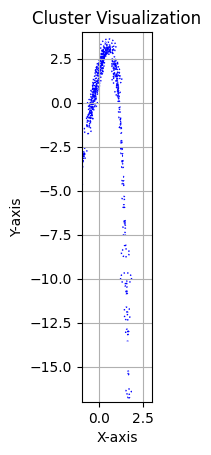

In [17]:
"""Visualization"""
fig, ax = plt.subplots()
for center,radius in zip(cluster_center.values(),cluster_radius.values()):
    circle = plt.Circle(center, radius, fill=False, linestyle='dotted', edgecolor='b')
    ax.add_artist(circle)

# Set axis limits
ax.set_xlim(boundaries[0])
ax.set_ylim(boundaries[1])
# ax.autoscale_view()

# # Add labels (optional)
# for i, center in cluster_center.items():
#     ax.text(center[0], center[1], f'Cluster {i+1}', ha='center', va='bottom')

# Add a title and labels (optional)
ax.set_title('Cluster Visualization')
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')

# Show the plot
plt.gca().set_aspect('equal', adjustable='box')  # Make the aspect ratio equal
plt.grid(True)
plt.show()
